In [13]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 데이터 경로 설정 (~/data 밑에 바로 train, val, test가 있음)
ROOT_PATH = os.path.expanduser("~/data")
TRAIN_PATH = os.path.join(ROOT_PATH, "train")
VAL_PATH = os.path.join(ROOT_PATH, "val")
TEST_PATH = os.path.join(ROOT_PATH, "test")

# 이미지 크기 및 배치 크기 설정
IMG_SIZE = (224, 224)  # 모델 입력 사이즈
BATCH_SIZE = 32

# 데이터 증강 및 로드
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

# 데이터 불러오기
train_data = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

val_data = val_datagen.flow_from_directory(
    VAL_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

test_data = test_datagen.flow_from_directory(
    TEST_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

# 클래스 확인
print("클래스 인덱스:", train_data.class_indices)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
클래스 인덱스: {'NORMAL': 0, 'PNEUMONIA': 1}


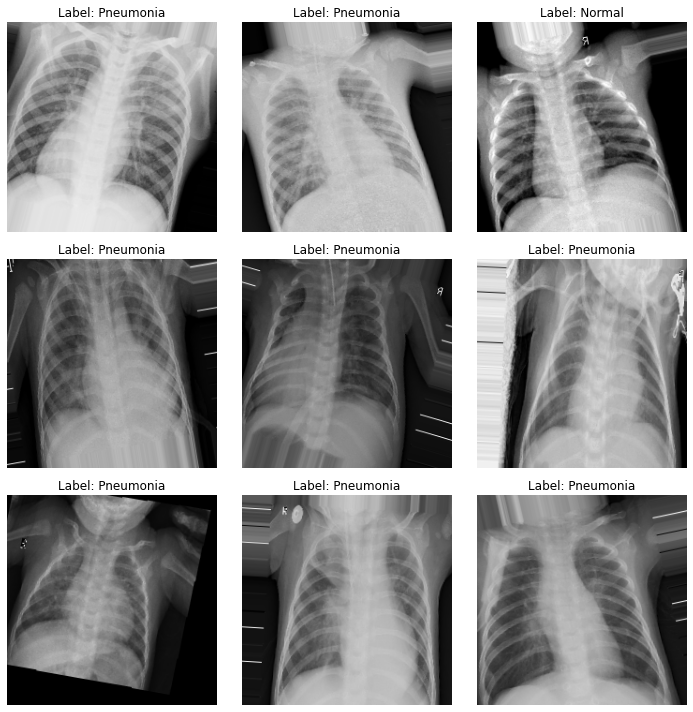

In [14]:
# 훈련 데이터에서 배치 가져오기
x_train_batch, y_train_batch = next(train_data)

# 시각화
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
axes = axes.ravel()

for i in range(9):
    axes[i].imshow(x_train_batch[i], cmap='gray')  # X-ray 데이터는 흑백 이미지
    axes[i].set_title(f"Label: {'Pneumonia' if y_train_batch[i] == 1 else 'Normal'}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()


In [18]:
def residual_block(x, filters, kernel_size=3, stride=1):
    """
    #Residual Block 정의 (기본 블록)
    """
    shortcut = x  # 원본 입력 저장
    
    # 첫 번째 컨볼루션
    x = layers.Conv2D(filters, kernel_size, strides=stride, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # 두 번째 컨볼루션
    x = layers.Conv2D(filters, kernel_size, strides=1, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    
    # 입력 차원이 다를 경우, 1x1 컨볼루션을 사용하여 차원 맞춤
    if stride != 1 or shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, 1, strides=stride, use_bias=False)(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    # Residual 연결 (Skip Connection)
    x = layers.Add()([x, shortcut])
    x = layers.ReLU()(x)
    
    return x

def build_resnet18(input_shape=(224, 224, 3), num_classes=1):
    """
    #ResNet-18 모델 생성
    """
    inputs = layers.Input(shape=input_shape)

    # 초기 컨볼루션 레이어
    x = layers.Conv2D(64, 7, strides=2, padding="same", use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

    # Residual Blocks (ResNet-18 구조)
    x = residual_block(x, 64)
    x = residual_block(x, 64)

    x = residual_block(x, 128, stride=2)
    x = residual_block(x, 128)

    x = residual_block(x, 256, stride=2)
    x = residual_block(x, 256)

    x = residual_block(x, 512, stride=2)
    x = residual_block(x, 512)

    # Global Average Pooling & Fully Connected Layer
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation="relu")(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation="sigmoid")(x)  # 이진 분류

    # 모델 생성
    model = models.Model(inputs, outputs)
    
    return model

# 모델 생성 및 요약 출력
resnet18_model = build_resnet18()
resnet18_model.summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 112, 112, 64) 9408        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_20 (BatchNo (None, 112, 112, 64) 256         conv2d_20[0][0]                  
__________________________________________________________________________________________________
re_lu_17 (ReLU)                 (None, 112, 112, 64) 0           batch_normalization_20[0][0]     
____________________________________________________________________________________________

In [17]:
# 클래스별 이미지 개수 확인
def count_images(directory):
    class_counts = {}
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            class_counts[class_name] = len(os.listdir(class_path))
    return class_counts

train_counts = count_images(TRAIN_PATH)
val_counts = count_images(VAL_PATH)
test_counts = count_images(TEST_PATH)

print("📊 훈련 데이터 클래스 개수:", train_counts)
print("📊 검증 데이터 클래스 개수:", val_counts)
print("📊 테스트 데이터 클래스 개수:", test_counts)


📊 훈련 데이터 클래스 개수: {'PNEUMONIA': 3875, 'NORMAL': 1341}
📊 검증 데이터 클래스 개수: {'PNEUMONIA': 8, 'NORMAL': 8}
📊 테스트 데이터 클래스 개수: {'PNEUMONIA': 390, 'NORMAL': 234}


In [22]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# 클래스 개수 확인
num_classes = 2  # Normal(0), Pneumonia(1)
class_labels = np.array([0, 1])  # 클래스 레이블 설정

# 훈련 데이터 클래스 분포 확인
class_counts = train_data.classes  # 모든 데이터의 클래스 리스트 (0 또는 1)

# 클래스 가중치 자동 계산
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=class_labels,
    y=class_counts
)

# 딕셔너리 형태로 변환
class_weight_dict = {i: class_weights[i] for i in range(num_classes)}

print("📊 클래스 가중치:", class_weight_dict)


📊 클래스 가중치: {0: 1.9448173005219984, 1: 0.6730322580645162}


In [23]:
# 모델 컴파일
resnet18_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.Recall()]
)


Epoch 1/10
163/163 [==============================] - 105s 641ms/step - loss: 0.0752 - accuracy: 0.9720 - recall: 0.9708 - val_loss: 0.2613 - val_accuracy: 0.8750 - val_recall: 0.8750
Epoch 2/10
163/163 [==============================] - 102s 625ms/step - loss: 0.0681 - accuracy: 0.9772 - recall: 0.9755 - val_loss: 0.4338 - val_accuracy: 0.8750 - val_recall: 0.7500
Epoch 3/10
163/163 [==============================] - 102s 624ms/step - loss: 0.0598 - accuracy: 0.9758 - recall: 0.9752 - val_loss: 2.5811 - val_accuracy: 0.5625 - val_recall: 1.0000
Epoch 4/10
163/163 [==============================] - 102s 623ms/step - loss: 0.0622 - accuracy: 0.9778 - recall: 0.9760 - val_loss: 4.9785 - val_accuracy: 0.5000 - val_recall: 0.0000e+00
Epoch 5/10
163/163 [==============================] - 102s 625ms/step - loss: 0.0523 - accuracy: 0.9795 - recall: 0.9781 - val_loss: 8.3332 - val_accuracy: 0.5000 - val_recall: 0.0000e+00
Epoch 6/10
163/163 [==============================] - 102s 624ms/step - 

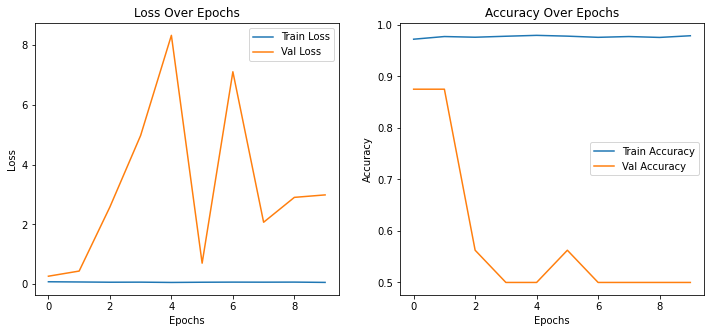

In [28]:
# 가중치 적용하여 학습 진행 (history 저장)
history = resnet18_model.fit(
    train_data,
    epochs=10,
    validation_data=val_data,
    class_weight=class_weight_dict  # 불균형 해결을 위한 클래스 가중치 적용
)

# Loss 그래프
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Epochs')

# Accuracy 그래프
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')

plt.show()


20/20 [==============================] - 6s 256ms/step - loss: 2.1228 - accuracy: 0.6266 - recall: 1.0000
📊 테스트 정확도 (Accuracy): 0.6266
📊 테스트 손실 (Loss): 2.1228
📊 테스트 Recall: 1.0000


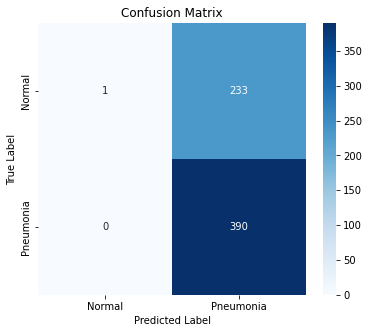

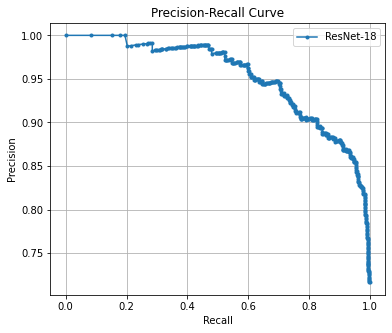

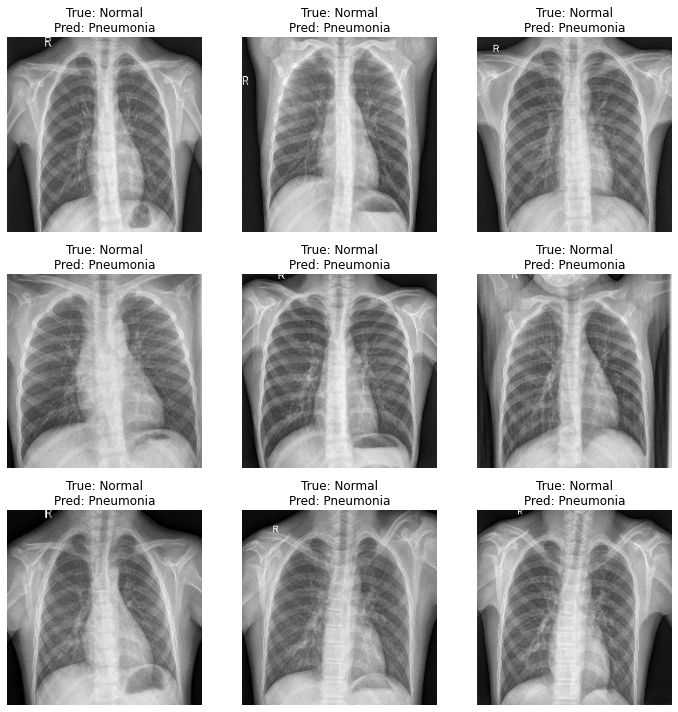

In [31]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_recall_curve
from tensorflow.keras.preprocessing.image import array_to_img

# 1️⃣ 테스트 데이터 평가
test_loss, test_acc, test_recall = resnet18_model.evaluate(test_data)
print(f"📊 테스트 정확도 (Accuracy): {test_acc:.4f}")
print(f"📊 테스트 손실 (Loss): {test_loss:.4f}")
print(f"📊 테스트 Recall: {test_recall:.4f}")

# 2️⃣ 예측 수행
y_pred_probs = resnet18_model.predict(test_data)  # 확률 값 출력
y_pred_labels = (y_pred_probs > 0.5).astype(int)  # Threshold = 0.5 적용
y_true_labels = test_data.classes  # 실제 라벨 가져오기

# 3️⃣ 혼동 행렬 시각화
cm = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# 4️⃣ Precision-Recall Curve 시각화
precision, recall, thresholds = precision_recall_curve(y_true_labels, y_pred_probs)
plt.figure(figsize=(6, 5))
plt.plot(recall, precision, marker=".", label="ResNet-18")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid()
plt.show()

# 5️⃣ 임의 샘플 예측 및 시각화
x_test_batch, y_test_batch = next(iter(test_data))
y_pred_probs_batch = resnet18_model.predict(x_test_batch)
y_pred_labels_batch = (y_pred_probs_batch > 0.5).astype(int)

fig, axes = plt.subplots(3, 3, figsize=(10, 10))
axes = axes.ravel()

for i in range(9):
    axes[i].imshow(array_to_img(x_test_batch[i]), cmap="gray")
    axes[i].set_title(f"True: {'Pneumonia' if y_test_batch[i] == 1 else 'Normal'}\nPred: {'Pneumonia' if y_pred_labels_batch[i] == 1 else 'Normal'}")
    axes[i].axis("off")

plt.tight_layout()
plt.show()
